In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf,read_raw_edf,read_raw_gdf,read_raw_fif
from mne.datasets import eegbci
from mne.decoding import CSP

In [2]:
def get_data():
    #path = "dataset\\bci_dataset\\train"
    #2b path 
    path = "dataset\\2b_moabb\\train"
    #2b file
    test_path = "dataset\\2b_moabb\\train\\0-raw.fif"
    #2a path
    #path = "dataset\\2amoabb\\train"
    
    #listed all data into list
    files = os.listdir(path)
    data_path = []
    for f in files:
        file = os.path.join(path,f)
        data_path.append(file)
        
    
    #tmin, tmax = -0.2, 0.4
    tmin, tmax = 1, 2
    event_id = dict(left=1, right = 2)

    #first is all data path second is one file
    #All subject
    raw = concatenate_raws([read_raw_fif(f, preload=True) for f in data_path])
    #one subject
    #raw = concatenate_raws([read_raw_fif(test_path, preload=True)])
    
    
    raw_data = raw.copy()
    print(raw_data.info)
    # strip channel names of "." characters
    raw_data.rename_channels(lambda x: x.strip('.'))

    # Apply band-pass filter
    #skip_by_annotation='edge'
    raw_data.filter(l_freq=0.5, h_freq=100,skip_by_annotation='edge')
    raw_data.notch_filter(50)

    events, _ = events_from_annotations(raw_data)
    print(events)
    
    picks = pick_types(raw_data.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
    print(picks)
    #delete eog band
    #picks = np.delete(picks,[3,4,5])
    
    # Read epochs (train will be done only between 1 and 2s)
    # reject_criteria = dict( eeg=100e-6)       # 100 µV
    epochs = Epochs(raw_data, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None,preload=True)
    #epochs.crop(tmin=1., tmax=None)
    labels = epochs.events[:, -1]-1
    return epochs.get_data(), labels,epochs,raw_data


epochs_data, labels,epochs1,raw= get_data()

Opening raw data file dataset\2b_moabb\train\0-raw.fif...
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...
Opening raw data file dataset\2b_moabb\train\1-raw.fif...
    Range : 0 ... 552451 =      0.000 ...  2209.804 secs
Ready.
Reading 0 ... 552451  =      0.000 ...  2209.804 secs...
Opening raw data file dataset\2b_moabb\train\10-raw.fif...
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...
Opening raw data file dataset\2b_moabb\train\11-raw.fif...
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...
Opening raw data file dataset\2b_moabb\train\12-raw.fif...
    Range : 0 ... 464674 =      0.000 ...  1858.696 secs
Ready.
Reading 0 ... 464674  =      0.000 ...  1858.696 secs...
Opening raw data file dataset\2b_moabb\train\13-raw.fif...
    Range : 0 ... 464674 =      0.000 ...  

In [3]:
# 280 events(epoch)
# 22 channel
# 256 Time(samples)
#(event,channel,time)
print(epochs_data.shape)
print(labels.shape)
print(epochs_data.shape[1])
print(labels)
print(raw.info['ch_names'])
print(raw.info['nchan'])

(6520, 3, 251)
(6520,)
3
[0 1 0 ... 0 1 0]
['C3', 'Cz', 'C4', 'EOG1', 'EOG2', 'EOG3', 'stim']
7


In [7]:
X = epochs_data.copy()
y = labels
print(X.shape)
print(y.shape)

(6520, 3, 251)
(6520,)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [9]:
class casual(nn.Module):
    def __init__(self,kernel_size=3,dilation=1):
        super(casual, self).__init__()
        self.pad = (kernel_size - 1) * dilation
        self.casual1 = nn.Conv1d(in_channels=3,out_channels=6,kernel_size=kernel_size,stride=1,padding=self.pad,dilation=dilation)
        self.casual2 = nn.Conv1d(in_channels=6,out_channels=12,kernel_size=kernel_size,stride=1,padding=self.pad,dilation=dilation)
        self.conv1_1 = nn.Conv1d(in_channels=3,out_channels=12,
                                                        kernel_size=1,stride=1,padding=0,dilation=1)
    def forward(self,x):
        x_iden = x
        x = self.casual1(x)
        x = x[:,:,:-self.pad]
        print(x.shape)
        x = self.casual2(x)
        x = x[:,:,:-self.pad]
        print(x.shape)
        x_iden = self.conv1_1(x_iden)
        print(x_iden.shape)
        x = x + x_iden
        return x

In [10]:
class First_SingleNet(nn.Module):
    def __init__(self):
        super().__init__()

        # define model architecture
        # torch.Size([36, 1, 64, 256])
        # temporal convolutional kernel 25 filter with size(11,1)
        #input [224, 1, 22, 256]
        # new input [96, 1, 3, 151]
        #A block
        
        #Temporal torch.Size([5216, 8, 1, 151])
        self.temporalConv = nn.Conv1d(in_channels=3,out_channels=8,kernel_size=3,stride=1)
        self.batchnorm1 = nn.BatchNorm1d(8,affine=False)
        #Spatial torch.Size([5216, 8, 1, 151])
        self.spatialConv = nn.Conv1d(in_channels=8,out_channels=8,kernel_size=1,stride=1)
        self.batchnorm2 = nn.BatchNorm1d(8,affine=False)
        #Maxx torch.Size([5216, 41, 1, 2])
        self.maxPooling = nn.MaxPool1d(3)
        
        #B block
        # 1st convo output [25,1,371]
        #input [224, 8, 1, 85]
        # new input [96, 8, 1, 50]
        
        self.firstConv = nn.Conv1d(in_channels=8, out_channels=8,kernel_size=1,stride=1)
        self.batchnorm3 = nn.BatchNorm1d(8, False)
        self.secondConv = nn.Conv1d(in_channels=8, out_channels=33,kernel_size=1,stride=1)
        self.batchnorm4 = nn.BatchNorm1d(8, False)
        self.maxPooling2 = nn.MaxPool1d(3)
        # out Secondblock torch.Size([5216, 41, 1, 16])
        
        #C block
        #input [224, 41, 1, 28]
        #new input [96, 41, 1, 16]
        
        self.classify = nn.Conv1d(in_channels=16,out_channels=41,kernel_size=1,stride=1)
        self.batchnorm5 = nn.BatchNorm1d(41, False) 
        #Classify torch.Size([5216, 41, 1, 6])
        self.maxPooling3 = nn.MaxPool1d(3)
        #Maxx torch.Size([5216, 41, 1, 2])
        self.flatten = nn.Flatten()
        #flatter torch.Size([5216, 82])
        self.elu = nn.ELU()
        #elu torch.Size([5216, 82])
        self.fully = nn.Linear(369,2) 
        #fully torch.Size([5216, 2])
        
        
    def forward(self, x):
        #Conv1d(1,ch,kernel_size=10) on tensor [batch=1, channels=1, time=400]
        
        x = self.temporalConv(x)
        x = self.batchnorm1(x)
        x = self.elu(x)
        x = F.dropout(x, 0.5)
        
        x = self.spatialConv(x)
        x = self.batchnorm2(x)
        x = self.elu(x)
        x = F.dropout(x, 0.5)
        x = self.maxPooling(x)

        
        out2 = self.firstConv(x)
        out2 = self.batchnorm3(x)
        out2 = self.elu(out2)
        out2 = F.dropout(out2,0.5)
        
        out2 = self.secondConv(out2)
        out2 = self.batchnorm4(x)
        out2 = self.elu(out2)
        out2 = F.dropout(out2,0.5)
        out3 = torch.cat((x,out2),1)
        out3 = self.maxPooling2(out3)
        
        
        out3 = self.classify(out3)
        out3 = self.batchnorm5(out3)
        out3 = self.elu(out3)
        out3 = F.dropout(out3,0.5)
        out3 = self.maxPooling3(out3)
        out3 = self.flatten(out3)
        out3 = self.elu(out3)
        out3 = self.fully(out3)
        out3 = self.elu(out3)
        out3 = F.log_softmax(out3, dim=1)
        
        return out3

In [12]:
class CNN(nn.Module):
    def __init__(self,kernel_size=3,dilation=1):
        super(CNN, self).__init__()
        self.pad = (kernel_size - 1) * dilation
        self.temporal= nn.Conv1d(in_channels=3,out_channels=25,kernel_size=11,stride=1)
        self.leaky = nn.LeakyReLU()
        self.spatial = nn.Conv1d(in_channels=25)
        
        
        
    def forward(self,x):
        print(x.shape)
        x = self.temporal(x)
        x = self.leaky(x)
        x = F.dropout(x,0.5)
        print(x.shape)
        
        
        return x


models = CNN()
for index,(x,y) in enumerate(train_iterator):
    x = x.to(device=device, dtype=torch.float32)
    y = x.to(device=device, dtype=torch.int64)
    print(x.shape)
    models(x)
    break

TypeError: __init__() missing 2 required positional arguments: 'out_channels' and 'kernel_size'

In [13]:
device = 'cpu'
models = First_SingleNet()

In [14]:
import torch.optim as optim

learning_rate = 0.01

optimizer = optim.Adam(models.parameters())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(models.parameters(), lr=learning_rate)

In [15]:
from torch.utils.data import TensorDataset

X_torch = torch.from_numpy(X).double()
y_torch = torch.from_numpy(y)
# Define dataset
ds = TensorDataset(X_torch, y_torch)

#Train test split
train_size = int(X_torch.size()[0] * 0.7)
valid_size = int(X_torch.size()[0] * 0.2)
test_size = int(X_torch.size()[0] * 0.1)

train_set, valid_set, test_set = torch.utils.data.random_split(ds, [train_size, valid_size, test_size])

BATCH_SIZE = 64 #keeping it binary so it fits GPU
#Train set loader
train_iterator = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
#Validation set loader
valid_iterator = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

#Test set loader
test_iterator = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

for index,(x,y) in enumerate(train_iterator):
    print(x.shape)

torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])
torch.Size([64, 3, 251])


In [11]:
def train(model, iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch, labels in iterator:
        print(batch.shape)
        #Move tensors to the configured device
        batch = batch.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(batch)
        print("Out" + str(outputs.shape))
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
        predictions = model(batch.float())
        _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
        total += labels.size(0)  #keep track of total
        correct += (predicted == labels).sum().item()  #.item() give the raw number
        acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
        epoch_acc = acc
        
    return epoch_loss / len(iterator), epoch_acc, predicted

In [12]:
def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch#.to(device)
            labels = labels#.to(device)

            predictions = model(batch.float())
            loss = criterion(predictions, labels)

            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator) , predicted

In [13]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [14]:
'''N_EPOCHS = 200

best_valid_loss = float('inf')
start_time = time.time()

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, predicted_train = train(models, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, predicted_eval = evaluate(models, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if (epoch+1) % 20 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')
            
        print(predicted_train)
        print(predicted_eval)
            
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print("Model:{} saved.".format(type(model).__name__))
        #torch.save(model.state_dict(), 'models/checkpoint.pth.tar')
        best_model_index = i         
           '''

'N_EPOCHS = 200\n\nbest_valid_loss = float(\'inf\')\nstart_time = time.time()\n\nfor epoch in range(N_EPOCHS):\n    start_time = time.time()\n\n    train_loss, train_acc, predicted_train = train(models, train_iterator, optimizer, criterion)\n    valid_loss, valid_acc, predicted_eval = evaluate(models, valid_iterator, criterion)\n\n    end_time = time.time()\n\n    epoch_mins, epoch_secs = epoch_time(start_time, end_time)\n        \n    if (epoch+1) % 20 == 0:\n        print(f\'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\')\n        print(f\'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%\')\n        print(f\'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%\')\n            \n        print(predicted_train)\n        print(predicted_eval)\n            \n    if valid_loss < best_valid_loss:\n        best_valid_loss = valid_loss\n        print("Model:{} saved.".format(type(model).__name__))\n        #torch.save(model.state_dict(), \'models/checkpoin

In [25]:
# Train
from common import train

lr = 1e-4
n_epochs = 300
patience = 300
weight_name = "SingleNet_2class_Con1Dnew_allsubject"
models.to(device=device) 
optimizer = optim.Adam(models.parameters(), lr=lr,weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

best_model,train_loss,valid_loss = train(models,train_iterator, valid_iterator, optimizer,criterion,n_epochs, patience, device,weight_name)


Starting epoch 1 / 300


avg train loss: 0.72: 100%|██████████| 72/72 [00:01<00:00, 43.67it/s]


---  Accuracy Training set : 49.52 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 110.38it/s]


---  Accuracy Validation set: 51.38 % 


best val loss inf -> 0.6938

Starting epoch 2 / 300


avg train loss: 0.71: 100%|██████████| 72/72 [00:01<00:00, 50.97it/s]


---  Accuracy Training set : 49.50 % 



avg val loss: 0.72: 100%|██████████| 21/21 [00:00<00:00, 111.95it/s]


---  Accuracy Validation set: 48.16 % 

Waiting += 1

Starting epoch 3 / 300


avg train loss: 0.70: 100%|██████████| 72/72 [00:01<00:00, 48.49it/s]


---  Accuracy Training set : 51.12 % 



avg val loss: 0.94: 100%|██████████| 21/21 [00:00<00:00, 81.68it/s]


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 4 / 300


avg train loss: 0.70: 100%|██████████| 72/72 [00:01<00:00, 50.66it/s]


---  Accuracy Training set : 50.96 % 



avg val loss: 0.72: 100%|██████████| 21/21 [00:00<00:00, 119.26it/s]


---  Accuracy Validation set: 48.62 % 

Waiting += 1

Starting epoch 5 / 300


avg train loss: 0.70: 100%|██████████| 72/72 [00:01<00:00, 52.16it/s]


---  Accuracy Training set : 49.82 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 65.25it/s]


---  Accuracy Validation set: 48.16 % 

Waiting += 1

Starting epoch 6 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 51.32it/s]


---  Accuracy Training set : 49.93 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 112.36it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 7 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 56.55it/s]


---  Accuracy Training set : 50.68 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 118.64it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 8 / 300


avg train loss: 0.70: 100%|██████████| 72/72 [00:01<00:00, 53.09it/s]


---  Accuracy Training set : 50.85 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 114.28it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 9 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 56.61it/s]


---  Accuracy Training set : 49.89 % 



avg val loss: 0.70: 100%|██████████| 21/21 [00:00<00:00, 119.07it/s]


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 10 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 49.61it/s]


---  Accuracy Training set : 50.61 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 104.63it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 11 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 55.19it/s]


---  Accuracy Training set : 50.57 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 75.68it/s]


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 12 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 47.55it/s]


---  Accuracy Training set : 49.36 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 111.85it/s]


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 13 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 52.19it/s]


---  Accuracy Training set : 50.33 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 113.89it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 14 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 54.97it/s]


---  Accuracy Training set : 51.25 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 105.94it/s]


---  Accuracy Validation set: 48.54 % 

Waiting += 1

Starting epoch 15 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 52.38it/s]


---  Accuracy Training set : 49.61 % 



avg val loss: 0.70: 100%|██████████| 21/21 [00:00<00:00, 98.92it/s] 


---  Accuracy Validation set: 48.01 % 

Waiting += 1

Starting epoch 16 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 55.83it/s]


---  Accuracy Training set : 50.66 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 105.57it/s]


---  Accuracy Validation set: 48.24 % 

Waiting += 1

Starting epoch 17 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 49.79it/s]


---  Accuracy Training set : 50.74 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 85.67it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 18 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 36.57it/s]


---  Accuracy Training set : 50.02 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 82.01it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 19 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 45.82it/s]


---  Accuracy Training set : 50.20 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 97.85it/s]


---  Accuracy Validation set: 48.47 % 

Waiting += 1

Starting epoch 20 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 48.41it/s]


---  Accuracy Training set : 52.02 % 



avg val loss: 0.71: 100%|██████████| 21/21 [00:00<00:00, 106.96it/s]


---  Accuracy Validation set: 48.24 % 

Waiting += 1

Starting epoch 21 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 49.16it/s]


---  Accuracy Training set : 51.60 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 100.80it/s]


---  Accuracy Validation set: 48.85 % 

Waiting += 1

Starting epoch 22 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 55.65it/s]


---  Accuracy Training set : 51.16 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 94.23it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 23 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 52.58it/s]


---  Accuracy Training set : 50.77 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 68.41it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 24 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 50.05it/s]


---  Accuracy Training set : 54.14 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 99.42it/s] 


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 25 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 47.30it/s]


---  Accuracy Training set : 51.84 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 70.14it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 26 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 48.11it/s]


---  Accuracy Training set : 52.45 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 93.25it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 27 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 51.91it/s]


---  Accuracy Training set : 52.37 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 118.49it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 28 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 52.72it/s]


---  Accuracy Training set : 51.67 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 120.51it/s]


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 29 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 51.06it/s]


---  Accuracy Training set : 52.76 % 



avg val loss: 0.71: 100%|██████████| 21/21 [00:00<00:00, 58.12it/s]


---  Accuracy Validation set: 48.24 % 

Waiting += 1

Starting epoch 30 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 53.03it/s]


---  Accuracy Training set : 51.73 % 



avg val loss: 0.70: 100%|██████████| 21/21 [00:00<00:00, 107.22it/s]


---  Accuracy Validation set: 48.08 % 

Waiting += 1

Starting epoch 31 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 58.53it/s]


---  Accuracy Training set : 53.83 % 



avg val loss: 2.06: 100%|██████████| 21/21 [00:00<00:00, 113.52it/s]


---  Accuracy Validation set: 51.30 % 

Waiting += 1

Starting epoch 32 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 57.93it/s]


---  Accuracy Training set : 54.25 % 



avg val loss: 1.12: 100%|██████████| 21/21 [00:00<00:00, 92.09it/s]


---  Accuracy Validation set: 47.93 % 

Waiting += 1

Starting epoch 33 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 55.62it/s]


---  Accuracy Training set : 54.14 % 



avg val loss: 0.84: 100%|██████████| 21/21 [00:00<00:00, 94.42it/s]


---  Accuracy Validation set: 47.55 % 

Waiting += 1

Starting epoch 34 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 59.38it/s]


---  Accuracy Training set : 54.82 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 107.67it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 35 / 300


avg train loss: 0.69: 100%|██████████| 72/72 [00:01<00:00, 58.47it/s]


---  Accuracy Training set : 55.00 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 98.69it/s]


---  Accuracy Validation set: 48.47 % 

Waiting += 1

Starting epoch 36 / 300


avg train loss: 0.68: 100%|██████████| 72/72 [00:01<00:00, 51.87it/s]


---  Accuracy Training set : 55.04 % 



avg val loss: 52.27: 100%|██████████| 21/21 [00:00<00:00, 65.98it/s]


---  Accuracy Validation set: 51.07 % 

Waiting += 1

Starting epoch 37 / 300


avg train loss: 0.68: 100%|██████████| 72/72 [00:01<00:00, 56.70it/s]


---  Accuracy Training set : 56.73 % 



avg val loss: 0.93: 100%|██████████| 21/21 [00:00<00:00, 78.97it/s]


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 38 / 300


avg train loss: 0.68: 100%|██████████| 72/72 [00:01<00:00, 58.29it/s]


---  Accuracy Training set : 57.32 % 



avg val loss: 1.17: 100%|██████████| 21/21 [00:00<00:00, 100.49it/s]


---  Accuracy Validation set: 47.93 % 

Waiting += 1

Starting epoch 39 / 300


avg train loss: 0.67: 100%|██████████| 72/72 [00:01<00:00, 52.30it/s]


---  Accuracy Training set : 58.13 % 



avg val loss: 2.10: 100%|██████████| 21/21 [00:00<00:00, 87.45it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 40 / 300


avg train loss: 0.67: 100%|██████████| 72/72 [00:01<00:00, 57.88it/s]


---  Accuracy Training set : 57.91 % 



avg val loss: 13.35: 100%|██████████| 21/21 [00:00<00:00, 89.68it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 41 / 300


avg train loss: 0.67: 100%|██████████| 72/72 [00:01<00:00, 58.16it/s]


---  Accuracy Training set : 58.28 % 



avg val loss: 1.46: 100%|██████████| 21/21 [00:00<00:00, 114.29it/s]


---  Accuracy Validation set: 48.24 % 

Waiting += 1

Starting epoch 42 / 300


avg train loss: 0.67: 100%|██████████| 72/72 [00:01<00:00, 58.35it/s]


---  Accuracy Training set : 58.87 % 



avg val loss: 1.23: 100%|██████████| 21/21 [00:00<00:00, 77.66it/s]


---  Accuracy Validation set: 48.93 % 

Waiting += 1

Starting epoch 43 / 300


avg train loss: 0.66: 100%|██████████| 72/72 [00:01<00:00, 54.64it/s]


---  Accuracy Training set : 60.78 % 



avg val loss: 0.99: 100%|██████████| 21/21 [00:00<00:00, 104.91it/s]


---  Accuracy Validation set: 48.47 % 

Waiting += 1

Starting epoch 44 / 300


avg train loss: 0.66: 100%|██████████| 72/72 [00:01<00:00, 58.62it/s]


---  Accuracy Training set : 59.90 % 



avg val loss: 9.74: 100%|██████████| 21/21 [00:00<00:00, 98.47it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 45 / 300


avg train loss: 0.66: 100%|██████████| 72/72 [00:01<00:00, 45.26it/s]


---  Accuracy Training set : 58.94 % 



avg val loss: 12.91: 100%|██████████| 21/21 [00:00<00:00, 63.19it/s]


---  Accuracy Validation set: 51.30 % 

Waiting += 1

Starting epoch 46 / 300


avg train loss: 0.66: 100%|██████████| 72/72 [00:01<00:00, 40.68it/s]


---  Accuracy Training set : 59.93 % 



avg val loss: 1.89: 100%|██████████| 21/21 [00:00<00:00, 67.51it/s]


---  Accuracy Validation set: 48.47 % 

Waiting += 1

Starting epoch 47 / 300


avg train loss: 0.66: 100%|██████████| 72/72 [00:01<00:00, 45.00it/s]


---  Accuracy Training set : 60.80 % 



avg val loss: 0.94: 100%|██████████| 21/21 [00:00<00:00, 87.13it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 48 / 300


avg train loss: 0.66: 100%|██████████| 72/72 [00:01<00:00, 48.24it/s]


---  Accuracy Training set : 60.39 % 



avg val loss: 59.74: 100%|██████████| 21/21 [00:00<00:00, 81.28it/s]


---  Accuracy Validation set: 51.84 % 

Waiting += 1

Starting epoch 49 / 300


avg train loss: 0.66: 100%|██████████| 72/72 [00:01<00:00, 50.45it/s]


---  Accuracy Training set : 60.47 % 



avg val loss: 21.96: 100%|██████████| 21/21 [00:00<00:00, 82.59it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 50 / 300


avg train loss: 0.66: 100%|██████████| 72/72 [00:01<00:00, 50.90it/s]


---  Accuracy Training set : 60.58 % 



avg val loss: 9.74: 100%|██████████| 21/21 [00:00<00:00, 77.66it/s]


---  Accuracy Validation set: 49.69 % 

Waiting += 1

Starting epoch 51 / 300


avg train loss: 0.66: 100%|██████████| 72/72 [00:01<00:00, 46.00it/s]


---  Accuracy Training set : 61.31 % 



avg val loss: 24.95: 100%|██████████| 21/21 [00:00<00:00, 81.71it/s]


---  Accuracy Validation set: 51.07 % 

Waiting += 1

Starting epoch 52 / 300


avg train loss: 0.66: 100%|██████████| 72/72 [00:01<00:00, 46.81it/s]


---  Accuracy Training set : 60.54 % 



avg val loss: 126.55: 100%|██████████| 21/21 [00:00<00:00, 93.36it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 53 / 300


avg train loss: 0.66: 100%|██████████| 72/72 [00:01<00:00, 57.47it/s]


---  Accuracy Training set : 61.39 % 



avg val loss: 8.10: 100%|██████████| 21/21 [00:00<00:00, 111.83it/s]


---  Accuracy Validation set: 48.70 % 

Waiting += 1

Starting epoch 54 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 53.47it/s]


---  Accuracy Training set : 61.79 % 



avg val loss: 91.32: 100%|██████████| 21/21 [00:00<00:00, 83.62it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 55 / 300


avg train loss: 0.66: 100%|██████████| 72/72 [00:01<00:00, 56.91it/s]


---  Accuracy Training set : 61.26 % 



avg val loss: 10.53: 100%|██████████| 21/21 [00:00<00:00, 113.06it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 56 / 300


avg train loss: 0.66: 100%|██████████| 72/72 [00:01<00:00, 56.80it/s]


---  Accuracy Training set : 61.44 % 



avg val loss: 1.69: 100%|██████████| 21/21 [00:00<00:00, 93.69it/s]


---  Accuracy Validation set: 49.85 % 

Waiting += 1

Starting epoch 57 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 56.23it/s]


---  Accuracy Training set : 62.16 % 



avg val loss: 6.42: 100%|██████████| 21/21 [00:00<00:00, 86.38it/s]


---  Accuracy Validation set: 49.54 % 

Waiting += 1

Starting epoch 58 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 46.50it/s]


---  Accuracy Training set : 61.81 % 



avg val loss: 2.63: 100%|██████████| 21/21 [00:00<00:00, 98.56it/s] 


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 59 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 47.94it/s]


---  Accuracy Training set : 62.05 % 



avg val loss: 2.24: 100%|██████████| 21/21 [00:00<00:00, 106.01it/s]


---  Accuracy Validation set: 49.23 % 

Waiting += 1

Starting epoch 60 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 56.73it/s]


---  Accuracy Training set : 61.88 % 



avg val loss: 60.68: 100%|██████████| 21/21 [00:00<00:00, 88.99it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 61 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 52.07it/s]


---  Accuracy Training set : 61.88 % 



avg val loss: 1.06: 100%|██████████| 21/21 [00:00<00:00, 101.18it/s]


---  Accuracy Validation set: 48.70 % 

Waiting += 1

Starting epoch 62 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 55.85it/s]


---  Accuracy Training set : 61.55 % 



avg val loss: 2.27: 100%|██████████| 21/21 [00:00<00:00, 94.12it/s]


---  Accuracy Validation set: 47.32 % 

Waiting += 1

Starting epoch 63 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 55.38it/s]


---  Accuracy Training set : 62.58 % 



avg val loss: 0.98: 100%|██████████| 21/21 [00:00<00:00, 87.96it/s]


---  Accuracy Validation set: 48.47 % 

Waiting += 1

Starting epoch 64 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 47.90it/s]


---  Accuracy Training set : 62.47 % 



avg val loss: 5.07: 100%|██████████| 21/21 [00:00<00:00, 93.03it/s]


---  Accuracy Validation set: 49.31 % 

Waiting += 1

Starting epoch 65 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 52.01it/s]


---  Accuracy Training set : 62.42 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 105.21it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 66 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 54.83it/s]


---  Accuracy Training set : 62.29 % 



avg val loss: 1.01: 100%|██████████| 21/21 [00:00<00:00, 97.67it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 67 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 50.72it/s]


---  Accuracy Training set : 62.12 % 



avg val loss: 7.67: 100%|██████████| 21/21 [00:00<00:00, 100.19it/s]


---  Accuracy Validation set: 52.53 % 

Waiting += 1

Starting epoch 68 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 55.04it/s]


---  Accuracy Training set : 61.50 % 



avg val loss: 48.87: 100%|██████████| 21/21 [00:00<00:00, 112.72it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 69 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 55.74it/s]


---  Accuracy Training set : 62.36 % 



avg val loss: 0.78: 100%|██████████| 21/21 [00:00<00:00, 106.86it/s]


---  Accuracy Validation set: 48.24 % 

Waiting += 1

Starting epoch 70 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 51.70it/s]


---  Accuracy Training set : 62.49 % 



avg val loss: 1.54: 100%|██████████| 21/21 [00:00<00:00, 118.47it/s]


---  Accuracy Validation set: 47.93 % 

Waiting += 1

Starting epoch 71 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 53.40it/s]


---  Accuracy Training set : 61.61 % 



avg val loss: 0.74: 100%|██████████| 21/21 [00:00<00:00, 112.38it/s]


---  Accuracy Validation set: 49.31 % 

Waiting += 1

Starting epoch 72 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 54.60it/s]


---  Accuracy Training set : 62.97 % 



avg val loss: 82.37: 100%|██████████| 21/21 [00:00<00:00, 89.92it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 73 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 52.05it/s]


---  Accuracy Training set : 62.75 % 



avg val loss: 18.01: 100%|██████████| 21/21 [00:00<00:00, 95.10it/s]


---  Accuracy Validation set: 51.23 % 

Waiting += 1

Starting epoch 74 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 55.32it/s]


---  Accuracy Training set : 62.55 % 



avg val loss: 14.00: 100%|██████████| 21/21 [00:00<00:00, 100.76it/s]


---  Accuracy Validation set: 52.38 % 

Waiting += 1

Starting epoch 75 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 53.32it/s]


---  Accuracy Training set : 62.73 % 



avg val loss: 73.19: 100%|██████████| 21/21 [00:00<00:00, 90.72it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 76 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 54.04it/s]


---  Accuracy Training set : 61.28 % 



avg val loss: 23.54: 100%|██████████| 21/21 [00:00<00:00, 69.70it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 77 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 54.75it/s]


---  Accuracy Training set : 62.25 % 



avg val loss: 14.60: 100%|██████████| 21/21 [00:00<00:00, 93.58it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 78 / 300


avg train loss: 0.65: 100%|██████████| 72/72 [00:01<00:00, 55.55it/s]


---  Accuracy Training set : 62.36 % 



avg val loss: 0.90: 100%|██████████| 21/21 [00:00<00:00, 109.41it/s]


---  Accuracy Validation set: 48.24 % 

Waiting += 1

Starting epoch 79 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 54.54it/s]


---  Accuracy Training set : 62.36 % 



avg val loss: 1.80: 100%|██████████| 21/21 [00:00<00:00, 111.21it/s]


---  Accuracy Validation set: 52.53 % 

Waiting += 1

Starting epoch 80 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 51.41it/s]


---  Accuracy Training set : 62.91 % 



avg val loss: 4.99: 100%|██████████| 21/21 [00:00<00:00, 86.56it/s]


---  Accuracy Validation set: 49.23 % 

Waiting += 1

Starting epoch 81 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 54.84it/s]


---  Accuracy Training set : 62.66 % 



avg val loss: 11.93: 100%|██████████| 21/21 [00:00<00:00, 96.21it/s]


---  Accuracy Validation set: 50.08 % 

Waiting += 1

Starting epoch 82 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 54.82it/s]


---  Accuracy Training set : 62.73 % 



avg val loss: 26.29: 100%|██████████| 21/21 [00:00<00:00, 91.46it/s]


---  Accuracy Validation set: 51.99 % 

Waiting += 1

Starting epoch 83 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 43.10it/s]


---  Accuracy Training set : 63.39 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 79.84it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 84 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 45.63it/s]


---  Accuracy Training set : 63.48 % 



avg val loss: 0.72: 100%|██████████| 21/21 [00:00<00:00, 56.86it/s]


---  Accuracy Validation set: 48.16 % 

Waiting += 1

Starting epoch 85 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 37.14it/s]


---  Accuracy Training set : 64.00 % 



avg val loss: 1.33: 100%|██████████| 21/21 [00:00<00:00, 46.26it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 86 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:02<00:00, 34.31it/s]


---  Accuracy Training set : 63.80 % 



avg val loss: 1.49: 100%|██████████| 21/21 [00:00<00:00, 89.44it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 87 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 52.61it/s]


---  Accuracy Training set : 64.02 % 



avg val loss: 2.11: 100%|██████████| 21/21 [00:00<00:00, 113.51it/s]


---  Accuracy Validation set: 51.61 % 

Waiting += 1

Starting epoch 88 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 50.42it/s]


---  Accuracy Training set : 63.01 % 



avg val loss: 0.97: 100%|██████████| 21/21 [00:00<00:00, 82.33it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 89 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 44.25it/s]


---  Accuracy Training set : 64.11 % 



avg val loss: 18.74: 100%|██████████| 21/21 [00:00<00:00, 76.28it/s]


---  Accuracy Validation set: 52.07 % 

Waiting += 1

Starting epoch 90 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 40.10it/s]


---  Accuracy Training set : 63.39 % 



avg val loss: 1.54: 100%|██████████| 21/21 [00:00<00:00, 61.93it/s]


---  Accuracy Validation set: 50.08 % 

Waiting += 1

Starting epoch 91 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:02<00:00, 31.85it/s]


---  Accuracy Training set : 64.22 % 



avg val loss: 22.16: 100%|██████████| 21/21 [00:00<00:00, 48.63it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 92 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 44.67it/s]


---  Accuracy Training set : 63.45 % 



avg val loss: 12.55: 100%|██████████| 21/21 [00:00<00:00, 62.94it/s]


---  Accuracy Validation set: 51.53 % 

Waiting += 1

Starting epoch 93 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:02<00:00, 35.33it/s]


---  Accuracy Training set : 63.67 % 



avg val loss: 1.08: 100%|██████████| 21/21 [00:00<00:00, 62.34it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 94 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 45.27it/s]


---  Accuracy Training set : 63.69 % 



avg val loss: 78.04: 100%|██████████| 21/21 [00:00<00:00, 80.90it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 95 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 44.53it/s]


---  Accuracy Training set : 63.67 % 



avg val loss: 6.73: 100%|██████████| 21/21 [00:00<00:00, 102.72it/s]


---  Accuracy Validation set: 51.07 % 

Waiting += 1

Starting epoch 96 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 48.29it/s]


---  Accuracy Training set : 62.62 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 84.26it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 97 / 300


avg train loss: 0.64: 100%|██████████| 72/72 [00:01<00:00, 42.89it/s]


---  Accuracy Training set : 63.45 % 



avg val loss: 26.95: 100%|██████████| 21/21 [00:00<00:00, 71.24it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 98 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 43.22it/s]


---  Accuracy Training set : 64.20 % 



avg val loss: 0.74: 100%|██████████| 21/21 [00:00<00:00, 69.39it/s]


---  Accuracy Validation set: 48.47 % 

Waiting += 1

Starting epoch 99 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 46.35it/s]


---  Accuracy Training set : 64.37 % 



avg val loss: 1.25: 100%|██████████| 21/21 [00:00<00:00, 100.53it/s]


---  Accuracy Validation set: 51.76 % 

Waiting += 1

Starting epoch 100 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 46.64it/s]


---  Accuracy Training set : 64.70 % 



avg val loss: 19.71: 100%|██████████| 21/21 [00:00<00:00, 79.45it/s]


---  Accuracy Validation set: 51.23 % 

Waiting += 1

Starting epoch 101 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 47.97it/s]


---  Accuracy Training set : 63.58 % 



avg val loss: 17.11: 100%|██████████| 21/21 [00:00<00:00, 87.31it/s]


---  Accuracy Validation set: 52.45 % 

Waiting += 1

Starting epoch 102 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 48.96it/s]


---  Accuracy Training set : 64.64 % 



avg val loss: 0.76: 100%|██████████| 21/21 [00:00<00:00, 75.20it/s]


---  Accuracy Validation set: 48.70 % 

Waiting += 1

Starting epoch 103 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 46.19it/s]


---  Accuracy Training set : 64.04 % 



avg val loss: 5.83: 100%|██████████| 21/21 [00:00<00:00, 80.78it/s]


---  Accuracy Validation set: 50.15 % 

Waiting += 1

Starting epoch 104 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 46.57it/s]


---  Accuracy Training set : 64.61 % 



avg val loss: 1.85: 100%|██████████| 21/21 [00:00<00:00, 87.75it/s]


---  Accuracy Validation set: 48.24 % 

Waiting += 1

Starting epoch 105 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 46.85it/s]


---  Accuracy Training set : 63.67 % 



avg val loss: 51.48: 100%|██████████| 21/21 [00:00<00:00, 91.76it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 106 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 46.31it/s]


---  Accuracy Training set : 63.08 % 



avg val loss: 35.47: 100%|██████████| 21/21 [00:00<00:00, 88.29it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 107 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 48.37it/s]


---  Accuracy Training set : 63.83 % 



avg val loss: 37.98: 100%|██████████| 21/21 [00:00<00:00, 85.35it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 108 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 47.06it/s]


---  Accuracy Training set : 64.68 % 



avg val loss: 0.87: 100%|██████████| 21/21 [00:00<00:00, 91.62it/s]


---  Accuracy Validation set: 47.85 % 

Waiting += 1

Starting epoch 109 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 43.43it/s]


---  Accuracy Training set : 64.86 % 



avg val loss: 0.99: 100%|██████████| 21/21 [00:00<00:00, 84.71it/s]


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 110 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 50.01it/s]


---  Accuracy Training set : 64.64 % 



avg val loss: 1.32: 100%|██████████| 21/21 [00:00<00:00, 80.32it/s]


---  Accuracy Validation set: 49.62 % 

Waiting += 1

Starting epoch 111 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 47.85it/s]


---  Accuracy Training set : 63.32 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 93.26it/s]


---  Accuracy Validation set: 48.54 % 

Waiting += 1

Starting epoch 112 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 44.57it/s]


---  Accuracy Training set : 64.15 % 



avg val loss: 33.12: 100%|██████████| 21/21 [00:00<00:00, 66.97it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 113 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 47.76it/s]


---  Accuracy Training set : 64.35 % 



avg val loss: 24.46: 100%|██████████| 21/21 [00:00<00:00, 98.16it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 114 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 41.61it/s]


---  Accuracy Training set : 64.75 % 



avg val loss: 14.09: 100%|██████████| 21/21 [00:00<00:00, 78.82it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 115 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 46.10it/s]


---  Accuracy Training set : 64.02 % 



avg val loss: 1.85: 100%|██████████| 21/21 [00:00<00:00, 71.14it/s]


---  Accuracy Validation set: 51.84 % 

Waiting += 1

Starting epoch 116 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:02<00:00, 33.10it/s]


---  Accuracy Training set : 64.31 % 



avg val loss: 0.75: 100%|██████████| 21/21 [00:00<00:00, 44.99it/s]


---  Accuracy Validation set: 47.85 % 

Waiting += 1

Starting epoch 117 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:02<00:00, 32.70it/s]


---  Accuracy Training set : 64.07 % 



avg val loss: 0.73: 100%|██████████| 21/21 [00:00<00:00, 82.25it/s]


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 118 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 52.51it/s]


---  Accuracy Training set : 65.14 % 



avg val loss: 14.36: 100%|██████████| 21/21 [00:00<00:00, 112.92it/s]


---  Accuracy Validation set: 51.61 % 

Waiting += 1

Starting epoch 119 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 50.82it/s]


---  Accuracy Training set : 63.98 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 82.37it/s] 


---  Accuracy Validation set: 48.47 % 

Waiting += 1

Starting epoch 120 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 45.79it/s]


---  Accuracy Training set : 63.96 % 



avg val loss: 1.36: 100%|██████████| 21/21 [00:00<00:00, 96.54it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 121 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 50.72it/s]


---  Accuracy Training set : 64.40 % 



avg val loss: 7.60: 100%|██████████| 21/21 [00:00<00:00, 105.84it/s]


---  Accuracy Validation set: 51.53 % 

Waiting += 1

Starting epoch 122 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 46.48it/s]


---  Accuracy Training set : 63.91 % 



avg val loss: 0.84: 100%|██████████| 21/21 [00:00<00:00, 96.55it/s]


---  Accuracy Validation set: 48.54 % 

Waiting += 1

Starting epoch 123 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 49.25it/s]


---  Accuracy Training set : 64.48 % 



avg val loss: 20.54: 100%|██████████| 21/21 [00:00<00:00, 109.92it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 124 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 41.49it/s]


---  Accuracy Training set : 64.64 % 



avg val loss: 0.73: 100%|██████████| 21/21 [00:00<00:00, 62.62it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 125 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:02<00:00, 33.24it/s]


---  Accuracy Training set : 63.91 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 62.92it/s]


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 126 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 37.64it/s]


---  Accuracy Training set : 64.44 % 



avg val loss: 24.01: 100%|██████████| 21/21 [00:00<00:00, 96.20it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 127 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 47.45it/s]


---  Accuracy Training set : 65.71 % 



avg val loss: 1.07: 100%|██████████| 21/21 [00:00<00:00, 69.67it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 128 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 39.21it/s]


---  Accuracy Training set : 65.01 % 



avg val loss: 0.70: 100%|██████████| 21/21 [00:00<00:00, 89.66it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 129 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 51.78it/s]


---  Accuracy Training set : 65.67 % 



avg val loss: 0.80: 100%|██████████| 21/21 [00:00<00:00, 78.22it/s]


---  Accuracy Validation set: 49.23 % 

Waiting += 1

Starting epoch 130 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 47.29it/s]


---  Accuracy Training set : 64.83 % 



avg val loss: 26.53: 100%|██████████| 21/21 [00:00<00:00, 53.24it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 131 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 39.29it/s]


---  Accuracy Training set : 65.38 % 



avg val loss: 0.87: 100%|██████████| 21/21 [00:00<00:00, 70.46it/s]


---  Accuracy Validation set: 48.77 % 

Waiting += 1

Starting epoch 132 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 45.05it/s]


---  Accuracy Training set : 64.92 % 



avg val loss: 9.82: 100%|██████████| 21/21 [00:00<00:00, 92.15it/s]


---  Accuracy Validation set: 51.76 % 

Waiting += 1

Starting epoch 133 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 54.98it/s]


---  Accuracy Training set : 64.83 % 



avg val loss: 38.85: 100%|██████████| 21/21 [00:00<00:00, 86.55it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 134 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 51.61it/s]


---  Accuracy Training set : 65.56 % 



avg val loss: 27.57: 100%|██████████| 21/21 [00:00<00:00, 108.24it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 135 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 45.24it/s]


---  Accuracy Training set : 65.97 % 



avg val loss: 57.19: 100%|██████████| 21/21 [00:00<00:00, 72.78it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 136 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 51.80it/s]


---  Accuracy Training set : 64.57 % 



avg val loss: 10.29: 100%|██████████| 21/21 [00:00<00:00, 96.73it/s]


---  Accuracy Validation set: 51.53 % 

Waiting += 1

Starting epoch 137 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 54.72it/s]


---  Accuracy Training set : 65.47 % 



avg val loss: 0.70: 100%|██████████| 21/21 [00:00<00:00, 110.52it/s]


---  Accuracy Validation set: 48.47 % 

Waiting += 1

Starting epoch 138 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 51.51it/s]


---  Accuracy Training set : 65.14 % 



avg val loss: 0.81: 100%|██████████| 21/21 [00:00<00:00, 107.69it/s]


---  Accuracy Validation set: 49.39 % 

Waiting += 1

Starting epoch 139 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 55.10it/s]


---  Accuracy Training set : 64.88 % 



avg val loss: 0.70: 100%|██████████| 21/21 [00:00<00:00, 120.27it/s]


---  Accuracy Validation set: 51.07 % 

Waiting += 1

Starting epoch 140 / 300


avg train loss: 0.63: 100%|██████████| 72/72 [00:01<00:00, 51.55it/s]


---  Accuracy Training set : 64.50 % 



avg val loss: 0.84: 100%|██████████| 21/21 [00:00<00:00, 107.94it/s]


---  Accuracy Validation set: 47.01 % 

Waiting += 1

Starting epoch 141 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 49.01it/s]


---  Accuracy Training set : 64.48 % 



avg val loss: 8.54: 100%|██████████| 21/21 [00:00<00:00, 93.80it/s]


---  Accuracy Validation set: 51.92 % 

Waiting += 1

Starting epoch 142 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 46.48it/s]


---  Accuracy Training set : 64.99 % 



avg val loss: 1.91: 100%|██████████| 21/21 [00:00<00:00, 87.60it/s] 


---  Accuracy Validation set: 52.22 % 

Waiting += 1

Starting epoch 143 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 39.91it/s]


---  Accuracy Training set : 65.05 % 



avg val loss: 4.96: 100%|██████████| 21/21 [00:00<00:00, 92.28it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 144 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:02<00:00, 35.99it/s]


---  Accuracy Training set : 66.35 % 



avg val loss: 2.83: 100%|██████████| 21/21 [00:00<00:00, 95.73it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 145 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 42.02it/s]


---  Accuracy Training set : 65.32 % 



avg val loss: 18.64: 100%|██████████| 21/21 [00:00<00:00, 67.70it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 146 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:02<00:00, 34.04it/s]


---  Accuracy Training set : 64.83 % 



avg val loss: 1.11: 100%|██████████| 21/21 [00:00<00:00, 105.78it/s]


---  Accuracy Validation set: 48.54 % 

Waiting += 1

Starting epoch 147 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 51.39it/s]


---  Accuracy Training set : 66.02 % 



avg val loss: 2.43: 100%|██████████| 21/21 [00:00<00:00, 93.78it/s]


---  Accuracy Validation set: 50.77 % 

Waiting += 1

Starting epoch 148 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:02<00:00, 26.18it/s]


---  Accuracy Training set : 65.71 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 39.12it/s]


---  Accuracy Validation set: 48.85 % 

Waiting += 1

Starting epoch 149 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 38.24it/s]


---  Accuracy Training set : 65.58 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 96.32it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 150 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 45.51it/s]


---  Accuracy Training set : 66.13 % 



avg val loss: 3.24: 100%|██████████| 21/21 [00:00<00:00, 92.05it/s]


---  Accuracy Validation set: 50.69 % 

Waiting += 1

Starting epoch 151 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 48.68it/s]


---  Accuracy Training set : 65.75 % 



avg val loss: 1.41: 100%|██████████| 21/21 [00:00<00:00, 111.08it/s]


---  Accuracy Validation set: 51.84 % 

Waiting += 1

Starting epoch 152 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 50.94it/s]


---  Accuracy Training set : 66.17 % 



avg val loss: 3.28: 100%|██████████| 21/21 [00:00<00:00, 109.74it/s]


---  Accuracy Validation set: 48.54 % 

Waiting += 1

Starting epoch 153 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 51.30it/s]


---  Accuracy Training set : 65.12 % 



avg val loss: 14.52: 100%|██████████| 21/21 [00:00<00:00, 92.62it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 154 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 44.55it/s]


---  Accuracy Training set : 65.03 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 94.15it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 155 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 55.29it/s]


---  Accuracy Training set : 65.99 % 



avg val loss: 2.38: 100%|██████████| 21/21 [00:00<00:00, 107.61it/s]


---  Accuracy Validation set: 48.24 % 

Waiting += 1

Starting epoch 156 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 56.23it/s]


---  Accuracy Training set : 65.43 % 



avg val loss: 1.39: 100%|██████████| 21/21 [00:00<00:00, 119.73it/s]


---  Accuracy Validation set: 52.45 % 

Waiting += 1

Starting epoch 157 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 51.60it/s]


---  Accuracy Training set : 66.30 % 



avg val loss: 1.15: 100%|██████████| 21/21 [00:00<00:00, 112.86it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 158 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 48.47it/s]


---  Accuracy Training set : 65.40 % 



avg val loss: 2.74: 100%|██████████| 21/21 [00:00<00:00, 94.33it/s]


---  Accuracy Validation set: 52.91 % 

Waiting += 1

Starting epoch 159 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 54.86it/s]


---  Accuracy Training set : 65.34 % 



avg val loss: 6.49: 100%|██████████| 21/21 [00:00<00:00, 104.70it/s]


---  Accuracy Validation set: 51.76 % 

Waiting += 1

Starting epoch 160 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 51.84it/s]


---  Accuracy Training set : 64.86 % 



avg val loss: 16.88: 100%|██████████| 21/21 [00:00<00:00, 97.76it/s]


---  Accuracy Validation set: 51.30 % 

Waiting += 1

Starting epoch 161 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 56.21it/s]


---  Accuracy Training set : 65.84 % 



avg val loss: 0.72: 100%|██████████| 21/21 [00:00<00:00, 116.46it/s]


---  Accuracy Validation set: 48.54 % 

Waiting += 1

Starting epoch 162 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 54.96it/s]


---  Accuracy Training set : 65.73 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 103.68it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 163 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 52.63it/s]


---  Accuracy Training set : 65.84 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 94.01it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 164 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 55.89it/s]


---  Accuracy Training set : 65.91 % 



avg val loss: 14.09: 100%|██████████| 21/21 [00:00<00:00, 104.53it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 165 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 56.63it/s]


---  Accuracy Training set : 65.62 % 



avg val loss: 0.71: 100%|██████████| 21/21 [00:00<00:00, 105.81it/s]


---  Accuracy Validation set: 47.01 % 

Waiting += 1

Starting epoch 166 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 54.91it/s]


---  Accuracy Training set : 66.48 % 



avg val loss: 0.73: 100%|██████████| 21/21 [00:00<00:00, 87.60it/s]


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 167 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 46.65it/s]


---  Accuracy Training set : 65.18 % 



avg val loss: 0.76: 100%|██████████| 21/21 [00:00<00:00, 92.93it/s]


---  Accuracy Validation set: 49.46 % 

Waiting += 1

Starting epoch 168 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 44.98it/s]


---  Accuracy Training set : 65.34 % 



avg val loss: 0.93: 100%|██████████| 21/21 [00:00<00:00, 87.07it/s]


---  Accuracy Validation set: 48.70 % 

Waiting += 1

Starting epoch 169 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 37.34it/s]


---  Accuracy Training set : 65.67 % 



avg val loss: 3.23: 100%|██████████| 21/21 [00:00<00:00, 78.82it/s]


---  Accuracy Validation set: 50.69 % 

Waiting += 1

Starting epoch 170 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 41.66it/s]


---  Accuracy Training set : 65.36 % 



avg val loss: 1.43: 100%|██████████| 21/21 [00:00<00:00, 113.47it/s]


---  Accuracy Validation set: 50.69 % 

Waiting += 1

Starting epoch 171 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 43.28it/s]


---  Accuracy Training set : 64.92 % 



avg val loss: 3.93: 100%|██████████| 21/21 [00:00<00:00, 84.91it/s]


---  Accuracy Validation set: 50.84 % 

Waiting += 1

Starting epoch 172 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 44.12it/s]


---  Accuracy Training set : 65.93 % 



avg val loss: 0.97: 100%|██████████| 21/21 [00:00<00:00, 74.47it/s]


---  Accuracy Validation set: 48.47 % 

Waiting += 1

Starting epoch 173 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 50.95it/s]


---  Accuracy Training set : 65.80 % 



avg val loss: 1.01: 100%|██████████| 21/21 [00:00<00:00, 120.06it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 174 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 56.08it/s]


---  Accuracy Training set : 65.49 % 



avg val loss: 19.24: 100%|██████████| 21/21 [00:00<00:00, 98.64it/s] 


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 175 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 46.67it/s]


---  Accuracy Training set : 65.84 % 



avg val loss: 0.70: 100%|██████████| 21/21 [00:00<00:00, 83.88it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 176 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 39.29it/s]


---  Accuracy Training set : 65.95 % 



avg val loss: 22.54: 100%|██████████| 21/21 [00:00<00:00, 53.12it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 177 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 36.30it/s]


---  Accuracy Training set : 66.08 % 



avg val loss: 3.47: 100%|██████████| 21/21 [00:00<00:00, 66.57it/s]


---  Accuracy Validation set: 51.07 % 

Waiting += 1

Starting epoch 178 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:02<00:00, 35.23it/s]


---  Accuracy Training set : 66.37 % 



avg val loss: 1.37: 100%|██████████| 21/21 [00:00<00:00, 74.93it/s]


---  Accuracy Validation set: 47.70 % 

Waiting += 1

Starting epoch 179 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:02<00:00, 35.74it/s]


---  Accuracy Training set : 66.19 % 



avg val loss: 1.17: 100%|██████████| 21/21 [00:00<00:00, 73.96it/s]


---  Accuracy Validation set: 50.23 % 

Waiting += 1

Starting epoch 180 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 40.80it/s]


---  Accuracy Training set : 65.43 % 



avg val loss: 0.72: 100%|██████████| 21/21 [00:00<00:00, 78.99it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 181 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 42.55it/s]


---  Accuracy Training set : 65.80 % 



avg val loss: 9.86: 100%|██████████| 21/21 [00:00<00:00, 78.78it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 182 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 42.46it/s]


---  Accuracy Training set : 65.80 % 



avg val loss: 2.17: 100%|██████████| 21/21 [00:00<00:00, 103.44it/s]


---  Accuracy Validation set: 49.54 % 

Waiting += 1

Starting epoch 183 / 300


avg train loss: 0.62: 100%|██████████| 72/72 [00:01<00:00, 39.89it/s]


---  Accuracy Training set : 65.53 % 



avg val loss: 4.27: 100%|██████████| 21/21 [00:00<00:00, 78.14it/s]


---  Accuracy Validation set: 50.31 % 

Waiting += 1

Starting epoch 184 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 42.30it/s]


---  Accuracy Training set : 65.84 % 



avg val loss: 5.63: 100%|██████████| 21/21 [00:00<00:00, 78.62it/s]


---  Accuracy Validation set: 51.61 % 

Waiting += 1

Starting epoch 185 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 43.64it/s]


---  Accuracy Training set : 66.17 % 



avg val loss: 0.74: 100%|██████████| 21/21 [00:00<00:00, 79.42it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 186 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 38.21it/s]


---  Accuracy Training set : 66.06 % 



avg val loss: 5.14: 100%|██████████| 21/21 [00:00<00:00, 91.54it/s]


---  Accuracy Validation set: 51.76 % 

Waiting += 1

Starting epoch 187 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 43.02it/s]


---  Accuracy Training set : 65.05 % 



avg val loss: 8.50: 100%|██████████| 21/21 [00:00<00:00, 100.75it/s]


---  Accuracy Validation set: 51.92 % 

Waiting += 1

Starting epoch 188 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 50.60it/s]


---  Accuracy Training set : 66.02 % 



avg val loss: 26.37: 100%|██████████| 21/21 [00:00<00:00, 84.45it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 189 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 49.10it/s]


---  Accuracy Training set : 66.37 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 76.21it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 190 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 47.39it/s]


---  Accuracy Training set : 65.95 % 



avg val loss: 2.60: 100%|██████████| 21/21 [00:00<00:00, 111.35it/s]


---  Accuracy Validation set: 52.15 % 

Waiting += 1

Starting epoch 191 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 49.58it/s]


---  Accuracy Training set : 65.32 % 



avg val loss: 0.84: 100%|██████████| 21/21 [00:00<00:00, 107.51it/s]


---  Accuracy Validation set: 47.55 % 

Waiting += 1

Starting epoch 192 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 43.31it/s]


---  Accuracy Training set : 66.48 % 



avg val loss: 0.71: 100%|██████████| 21/21 [00:00<00:00, 71.35it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 193 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 38.52it/s]


---  Accuracy Training set : 66.39 % 



avg val loss: 7.11: 100%|██████████| 21/21 [00:00<00:00, 82.05it/s]


---  Accuracy Validation set: 51.46 % 

Waiting += 1

Starting epoch 194 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 43.60it/s]


---  Accuracy Training set : 66.26 % 



avg val loss: 0.76: 100%|██████████| 21/21 [00:00<00:00, 91.55it/s]


---  Accuracy Validation set: 48.24 % 

Waiting += 1

Starting epoch 195 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:02<00:00, 35.19it/s]


---  Accuracy Training set : 66.21 % 



avg val loss: 1.00: 100%|██████████| 21/21 [00:00<00:00, 85.85it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 196 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 45.99it/s]


---  Accuracy Training set : 66.70 % 



avg val loss: 1.51: 100%|██████████| 21/21 [00:00<00:00, 94.74it/s]


---  Accuracy Validation set: 51.92 % 

Waiting += 1

Starting epoch 197 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 49.81it/s]


---  Accuracy Training set : 65.84 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 89.01it/s]


---  Accuracy Validation set: 48.47 % 

Waiting += 1

Starting epoch 198 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 46.45it/s]


---  Accuracy Training set : 65.53 % 



avg val loss: 16.41: 100%|██████████| 21/21 [00:00<00:00, 102.89it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 199 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 50.31it/s]


---  Accuracy Training set : 66.54 % 



avg val loss: 2.84: 100%|██████████| 21/21 [00:00<00:00, 84.03it/s]


---  Accuracy Validation set: 52.61 % 

Waiting += 1

Starting epoch 200 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 48.43it/s]


---  Accuracy Training set : 67.00 % 



avg val loss: 4.40: 100%|██████████| 21/21 [00:00<00:00, 88.80it/s]


---  Accuracy Validation set: 51.46 % 

Waiting += 1

Starting epoch 201 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 49.46it/s]


---  Accuracy Training set : 65.51 % 



avg val loss: 1.38: 100%|██████████| 21/21 [00:00<00:00, 83.91it/s]


---  Accuracy Validation set: 49.85 % 

Waiting += 1

Starting epoch 202 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 49.98it/s]


---  Accuracy Training set : 65.99 % 



avg val loss: 6.67: 100%|██████████| 21/21 [00:00<00:00, 91.11it/s]


---  Accuracy Validation set: 51.84 % 

Waiting += 1

Starting epoch 203 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 44.96it/s]


---  Accuracy Training set : 65.56 % 



avg val loss: 1.81: 100%|██████████| 21/21 [00:00<00:00, 98.85it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 204 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 43.63it/s]


---  Accuracy Training set : 67.07 % 



avg val loss: 19.00: 100%|██████████| 21/21 [00:00<00:00, 94.54it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 205 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 50.58it/s]


---  Accuracy Training set : 66.43 % 



avg val loss: 1.87: 100%|██████████| 21/21 [00:00<00:00, 95.16it/s]


---  Accuracy Validation set: 52.84 % 

Waiting += 1

Starting epoch 206 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 48.44it/s]


---  Accuracy Training set : 66.37 % 



avg val loss: 0.71: 100%|██████████| 21/21 [00:00<00:00, 97.52it/s]


---  Accuracy Validation set: 48.62 % 

Waiting += 1

Starting epoch 207 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 50.97it/s]


---  Accuracy Training set : 66.26 % 



avg val loss: 0.70: 100%|██████████| 21/21 [00:00<00:00, 90.51it/s]


---  Accuracy Validation set: 48.85 % 

Waiting += 1

Starting epoch 208 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 51.51it/s]


---  Accuracy Training set : 67.35 % 



avg val loss: 1.09: 100%|██████████| 21/21 [00:00<00:00, 111.40it/s]


---  Accuracy Validation set: 51.76 % 

Waiting += 1

Starting epoch 209 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 49.13it/s]


---  Accuracy Training set : 66.52 % 



avg val loss: 2.89: 100%|██████████| 21/21 [00:00<00:00, 111.01it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 210 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 50.95it/s]


---  Accuracy Training set : 66.81 % 



avg val loss: 2.00: 100%|██████████| 21/21 [00:00<00:00, 96.26it/s]


---  Accuracy Validation set: 49.39 % 

Waiting += 1

Starting epoch 211 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 51.47it/s]


---  Accuracy Training set : 66.70 % 



avg val loss: 3.28: 100%|██████████| 21/21 [00:00<00:00, 109.23it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 212 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 48.20it/s]


---  Accuracy Training set : 66.24 % 



avg val loss: 2.80: 100%|██████████| 21/21 [00:00<00:00, 102.10it/s]


---  Accuracy Validation set: 51.30 % 

Waiting += 1

Starting epoch 213 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 44.06it/s]


---  Accuracy Training set : 66.87 % 



avg val loss: 0.73: 100%|██████████| 21/21 [00:00<00:00, 85.28it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 214 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 52.60it/s]


---  Accuracy Training set : 66.28 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 101.90it/s]


---  Accuracy Validation set: 48.70 % 

Waiting += 1

Starting epoch 215 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 49.59it/s]


---  Accuracy Training set : 66.56 % 



avg val loss: 3.22: 100%|██████████| 21/21 [00:00<00:00, 97.67it/s]


---  Accuracy Validation set: 50.38 % 

Waiting += 1

Starting epoch 216 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 48.22it/s]


---  Accuracy Training set : 66.15 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 83.62it/s]


---  Accuracy Validation set: 48.93 % 

Waiting += 1

Starting epoch 217 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 38.33it/s]


---  Accuracy Training set : 66.76 % 



avg val loss: 4.24: 100%|██████████| 21/21 [00:00<00:00, 94.03it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 218 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 44.69it/s]


---  Accuracy Training set : 66.89 % 



avg val loss: 1.21: 100%|██████████| 21/21 [00:00<00:00, 98.56it/s]


---  Accuracy Validation set: 51.61 % 

Waiting += 1

Starting epoch 219 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 47.41it/s]


---  Accuracy Training set : 66.26 % 



avg val loss: 0.78: 100%|██████████| 21/21 [00:00<00:00, 92.90it/s]


---  Accuracy Validation set: 49.00 % 

Waiting += 1

Starting epoch 220 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 52.58it/s]


---  Accuracy Training set : 66.10 % 



avg val loss: 10.43: 100%|██████████| 21/21 [00:00<00:00, 108.07it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 221 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 49.42it/s]


---  Accuracy Training set : 66.81 % 



avg val loss: 7.48: 100%|██████████| 21/21 [00:00<00:00, 101.58it/s]


---  Accuracy Validation set: 51.53 % 

Waiting += 1

Starting epoch 222 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 51.83it/s]


---  Accuracy Training set : 66.59 % 



avg val loss: 30.81: 100%|██████████| 21/21 [00:00<00:00, 92.69it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 223 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 52.15it/s]


---  Accuracy Training set : 67.51 % 



avg val loss: 0.85: 100%|██████████| 21/21 [00:00<00:00, 94.69it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 224 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 45.63it/s]


---  Accuracy Training set : 66.89 % 



avg val loss: 9.24: 100%|██████████| 21/21 [00:00<00:00, 110.98it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 225 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 42.24it/s]


---  Accuracy Training set : 66.30 % 



avg val loss: 1.69: 100%|██████████| 21/21 [00:00<00:00, 76.62it/s]


---  Accuracy Validation set: 51.15 % 

Waiting += 1

Starting epoch 226 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 42.18it/s]


---  Accuracy Training set : 65.62 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 68.36it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 227 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 39.65it/s]


---  Accuracy Training set : 66.59 % 



avg val loss: 1.51: 100%|██████████| 21/21 [00:00<00:00, 86.86it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 228 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 47.63it/s]


---  Accuracy Training set : 66.50 % 



avg val loss: 1.04: 100%|██████████| 21/21 [00:00<00:00, 93.71it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 229 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 46.40it/s]


---  Accuracy Training set : 67.00 % 



avg val loss: 1.26: 100%|██████████| 21/21 [00:00<00:00, 97.98it/s]


---  Accuracy Validation set: 50.08 % 

Waiting += 1

Starting epoch 230 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 45.10it/s]


---  Accuracy Training set : 66.72 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 83.73it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 231 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 47.42it/s]


---  Accuracy Training set : 66.48 % 



avg val loss: 2.79: 100%|██████████| 21/21 [00:00<00:00, 91.17it/s]


---  Accuracy Validation set: 52.68 % 

Waiting += 1

Starting epoch 232 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 38.56it/s]


---  Accuracy Training set : 66.85 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 107.12it/s]


---  Accuracy Validation set: 47.85 % 

Waiting += 1

Starting epoch 233 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 52.35it/s]


---  Accuracy Training set : 66.17 % 



avg val loss: 10.04: 100%|██████████| 21/21 [00:00<00:00, 91.97it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 234 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 44.49it/s]


---  Accuracy Training set : 66.52 % 



avg val loss: 3.82: 100%|██████████| 21/21 [00:00<00:00, 79.66it/s]


---  Accuracy Validation set: 51.30 % 

Waiting += 1

Starting epoch 235 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 44.84it/s]


---  Accuracy Training set : 66.81 % 



avg val loss: 0.70: 100%|██████████| 21/21 [00:00<00:00, 101.06it/s]


---  Accuracy Validation set: 48.24 % 

Waiting += 1

Starting epoch 236 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 51.20it/s]


---  Accuracy Training set : 66.96 % 



avg val loss: 2.02: 100%|██████████| 21/21 [00:00<00:00, 91.39it/s]


---  Accuracy Validation set: 50.23 % 

Waiting += 1

Starting epoch 237 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 37.27it/s]


---  Accuracy Training set : 66.72 % 



avg val loss: 17.35: 100%|██████████| 21/21 [00:00<00:00, 92.78it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 238 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 42.71it/s]


---  Accuracy Training set : 66.74 % 



avg val loss: 1.55: 100%|██████████| 21/21 [00:00<00:00, 85.67it/s] 


---  Accuracy Validation set: 52.07 % 

Waiting += 1

Starting epoch 239 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 38.26it/s]


---  Accuracy Training set : 67.42 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 90.44it/s]


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 240 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 42.96it/s]


---  Accuracy Training set : 66.41 % 



avg val loss: 0.99: 100%|██████████| 21/21 [00:00<00:00, 95.60it/s] 


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 241 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 49.40it/s]


---  Accuracy Training set : 66.50 % 



avg val loss: 8.49: 100%|██████████| 21/21 [00:00<00:00, 92.12it/s]


---  Accuracy Validation set: 51.30 % 

Waiting += 1

Starting epoch 242 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 51.61it/s]


---  Accuracy Training set : 67.16 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 102.49it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 243 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:02<00:00, 35.86it/s]


---  Accuracy Training set : 67.53 % 



avg val loss: 20.43: 100%|██████████| 21/21 [00:00<00:00, 71.40it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 244 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 47.08it/s]


---  Accuracy Training set : 67.24 % 



avg val loss: 0.70: 100%|██████████| 21/21 [00:00<00:00, 95.18it/s] 


---  Accuracy Validation set: 48.24 % 

Waiting += 1

Starting epoch 245 / 300


avg train loss: 0.59: 100%|██████████| 72/72 [00:01<00:00, 42.73it/s]


---  Accuracy Training set : 67.44 % 



avg val loss: 0.93: 100%|██████████| 21/21 [00:00<00:00, 91.50it/s]


---  Accuracy Validation set: 48.47 % 

Waiting += 1

Starting epoch 246 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:02<00:00, 35.36it/s]


---  Accuracy Training set : 66.74 % 



avg val loss: 0.83: 100%|██████████| 21/21 [00:00<00:00, 80.89it/s]


---  Accuracy Validation set: 51.30 % 

Waiting += 1

Starting epoch 247 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 50.45it/s]


---  Accuracy Training set : 67.35 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 126.04it/s]


---  Accuracy Validation set: 49.85 % 

Waiting += 1

Starting epoch 248 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 48.34it/s]


---  Accuracy Training set : 66.78 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 88.41it/s]


---  Accuracy Validation set: 48.54 % 

Waiting += 1

Starting epoch 249 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 42.47it/s]


---  Accuracy Training set : 66.50 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 85.62it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 250 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 36.08it/s]


---  Accuracy Training set : 66.61 % 



avg val loss: 1.24: 100%|██████████| 21/21 [00:00<00:00, 98.60it/s]


---  Accuracy Validation set: 51.92 % 

Waiting += 1

Starting epoch 251 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 52.12it/s]


---  Accuracy Training set : 67.44 % 



avg val loss: 1.06: 100%|██████████| 21/21 [00:00<00:00, 119.71it/s]


---  Accuracy Validation set: 51.07 % 

Waiting += 1

Starting epoch 252 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 56.35it/s]


---  Accuracy Training set : 67.05 % 



avg val loss: 1.43: 100%|██████████| 21/21 [00:00<00:00, 114.16it/s]


---  Accuracy Validation set: 50.54 % 

Waiting += 1

Starting epoch 253 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 46.62it/s]


---  Accuracy Training set : 66.37 % 



avg val loss: 36.45: 100%|██████████| 21/21 [00:00<00:00, 83.39it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 254 / 300


avg train loss: 0.59: 100%|██████████| 72/72 [00:01<00:00, 38.98it/s]


---  Accuracy Training set : 67.84 % 



avg val loss: 0.72: 100%|██████████| 21/21 [00:00<00:00, 92.95it/s]


---  Accuracy Validation set: 49.54 % 

Waiting += 1

Starting epoch 255 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 37.68it/s]


---  Accuracy Training set : 66.70 % 



avg val loss: 0.72: 100%|██████████| 21/21 [00:00<00:00, 95.89it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 256 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 51.20it/s]


---  Accuracy Training set : 67.44 % 



avg val loss: 5.04: 100%|██████████| 21/21 [00:00<00:00, 111.66it/s]


---  Accuracy Validation set: 50.46 % 

Waiting += 1

Starting epoch 257 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 43.78it/s]


---  Accuracy Training set : 66.30 % 



avg val loss: 1.26: 100%|██████████| 21/21 [00:00<00:00, 109.14it/s]


---  Accuracy Validation set: 52.45 % 

Waiting += 1

Starting epoch 258 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 48.30it/s]


---  Accuracy Training set : 66.72 % 



avg val loss: 1.58: 100%|██████████| 21/21 [00:00<00:00, 79.78it/s]


---  Accuracy Validation set: 49.54 % 

Waiting += 1

Starting epoch 259 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 47.51it/s]


---  Accuracy Training set : 66.28 % 



avg val loss: 3.52: 100%|██████████| 21/21 [00:00<00:00, 111.87it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 260 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 56.75it/s]


---  Accuracy Training set : 67.20 % 



avg val loss: 16.11: 100%|██████████| 21/21 [00:00<00:00, 106.54it/s]


---  Accuracy Validation set: 51.76 % 

Waiting += 1

Starting epoch 261 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 54.16it/s]


---  Accuracy Training set : 68.01 % 



avg val loss: 0.71: 100%|██████████| 21/21 [00:00<00:00, 89.02it/s]


---  Accuracy Validation set: 47.85 % 

Waiting += 1

Starting epoch 262 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 44.91it/s]


---  Accuracy Training set : 66.87 % 



avg val loss: 4.76: 100%|██████████| 21/21 [00:00<00:00, 82.15it/s]


---  Accuracy Validation set: 51.30 % 

Waiting += 1

Starting epoch 263 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 50.41it/s]


---  Accuracy Training set : 66.65 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 103.61it/s]


---  Accuracy Validation set: 48.54 % 

Waiting += 1

Starting epoch 264 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 57.59it/s]


---  Accuracy Training set : 66.91 % 



avg val loss: 0.70: 100%|██████████| 21/21 [00:00<00:00, 114.15it/s]


---  Accuracy Validation set: 48.47 % 

Waiting += 1

Starting epoch 265 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 51.53it/s]


---  Accuracy Training set : 67.35 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 96.61it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 266 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 56.17it/s]


---  Accuracy Training set : 67.07 % 



avg val loss: 14.93: 100%|██████████| 21/21 [00:00<00:00, 109.85it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 267 / 300


avg train loss: 0.59: 100%|██████████| 72/72 [00:01<00:00, 56.04it/s]


---  Accuracy Training set : 67.53 % 



avg val loss: 0.71: 100%|██████████| 21/21 [00:00<00:00, 114.52it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 268 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 45.06it/s]


---  Accuracy Training set : 67.22 % 



avg val loss: 0.70: 100%|██████████| 21/21 [00:00<00:00, 103.32it/s]


---  Accuracy Validation set: 49.08 % 

Waiting += 1

Starting epoch 269 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 56.83it/s]


---  Accuracy Training set : 66.70 % 



avg val loss: 1.98: 100%|██████████| 21/21 [00:00<00:00, 116.26it/s]


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 270 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 52.33it/s]


---  Accuracy Training set : 67.57 % 



avg val loss: 0.71: 100%|██████████| 21/21 [00:00<00:00, 96.58it/s] 


---  Accuracy Validation set: 48.77 % 

Waiting += 1

Starting epoch 271 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 49.76it/s]


---  Accuracy Training set : 66.50 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 109.33it/s]


---  Accuracy Validation set: 48.62 % 

Waiting += 1

Starting epoch 272 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 44.99it/s]


---  Accuracy Training set : 67.22 % 



avg val loss: 10.16: 100%|██████████| 21/21 [00:00<00:00, 86.26it/s]


---  Accuracy Validation set: 50.23 % 

Waiting += 1

Starting epoch 273 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:01<00:00, 55.01it/s]


---  Accuracy Training set : 66.72 % 



avg val loss: 1.16: 100%|██████████| 21/21 [00:00<00:00, 109.81it/s]


---  Accuracy Validation set: 51.46 % 

Waiting += 1

Starting epoch 274 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 46.03it/s]


---  Accuracy Training set : 67.70 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 105.15it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 275 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 44.91it/s]


---  Accuracy Training set : 66.70 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 102.60it/s]


---  Accuracy Validation set: 47.70 % 

Waiting += 1

Starting epoch 276 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 57.52it/s]


---  Accuracy Training set : 66.81 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 127.14it/s]


---  Accuracy Validation set: 49.54 % 

Waiting += 1

Starting epoch 277 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 53.06it/s]


---  Accuracy Training set : 66.98 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 115.49it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 278 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 55.92it/s]


---  Accuracy Training set : 66.96 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 112.05it/s]


---  Accuracy Validation set: 48.54 % 

Waiting += 1

Starting epoch 279 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 52.10it/s]


---  Accuracy Training set : 66.78 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 92.96it/s]


---  Accuracy Validation set: 48.16 % 

Waiting += 1

Starting epoch 280 / 300


avg train loss: 0.59: 100%|██████████| 72/72 [00:01<00:00, 40.83it/s]


---  Accuracy Training set : 67.84 % 



avg val loss: 14.62: 100%|██████████| 21/21 [00:00<00:00, 85.97it/s]


---  Accuracy Validation set: 51.61 % 

Waiting += 1

Starting epoch 281 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:02<00:00, 30.06it/s]


---  Accuracy Training set : 66.35 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 89.39it/s]


---  Accuracy Validation set: 48.54 % 

Waiting += 1

Starting epoch 282 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 42.63it/s]


---  Accuracy Training set : 66.52 % 



avg val loss: 3.88: 100%|██████████| 21/21 [00:00<00:00, 69.94it/s]


---  Accuracy Validation set: 51.99 % 

Waiting += 1

Starting epoch 283 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 43.97it/s]


---  Accuracy Training set : 67.31 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 85.64it/s]


---  Accuracy Validation set: 50.23 % 

Waiting += 1

Starting epoch 284 / 300


avg train loss: 0.59: 100%|██████████| 72/72 [00:01<00:00, 40.71it/s]


---  Accuracy Training set : 67.77 % 



avg val loss: 0.70: 100%|██████████| 21/21 [00:00<00:00, 97.04it/s]


---  Accuracy Validation set: 47.62 % 

Waiting += 1

Starting epoch 285 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 44.78it/s]


---  Accuracy Training set : 66.91 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 94.86it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 286 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 49.93it/s]


---  Accuracy Training set : 66.85 % 



avg val loss: 1.02: 100%|██████████| 21/21 [00:00<00:00, 108.21it/s]


---  Accuracy Validation set: 48.39 % 

Waiting += 1

Starting epoch 287 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 45.38it/s]


---  Accuracy Training set : 66.26 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 83.63it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 288 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 41.71it/s]


---  Accuracy Training set : 67.35 % 



avg val loss: 9.61: 100%|██████████| 21/21 [00:00<00:00, 111.53it/s]


---  Accuracy Validation set: 51.84 % 

Waiting += 1

Starting epoch 289 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 47.52it/s]


---  Accuracy Training set : 67.09 % 



avg val loss: 0.83: 100%|██████████| 21/21 [00:00<00:00, 45.17it/s]


---  Accuracy Validation set: 50.23 % 

Waiting += 1

Starting epoch 290 / 300


avg train loss: 0.59: 100%|██████████| 72/72 [00:01<00:00, 39.53it/s]


---  Accuracy Training set : 66.96 % 



avg val loss: 0.70: 100%|██████████| 21/21 [00:00<00:00, 79.57it/s]


---  Accuracy Validation set: 47.39 % 

Waiting += 1

Starting epoch 291 / 300


avg train loss: 0.59: 100%|██████████| 72/72 [00:01<00:00, 37.88it/s]


---  Accuracy Training set : 67.66 % 



avg val loss: 1.43: 100%|██████████| 21/21 [00:00<00:00, 80.57it/s]


---  Accuracy Validation set: 49.08 % 

Waiting += 1

Starting epoch 292 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 45.54it/s]


---  Accuracy Training set : 67.24 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 86.64it/s]


---  Accuracy Validation set: 48.24 % 

Waiting += 1

Starting epoch 293 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:02<00:00, 33.18it/s]


---  Accuracy Training set : 68.01 % 



avg val loss: 0.71: 100%|██████████| 21/21 [00:00<00:00, 86.16it/s]


---  Accuracy Validation set: 47.09 % 

Waiting += 1

Starting epoch 294 / 300


avg train loss: 0.61: 100%|██████████| 72/72 [00:02<00:00, 29.19it/s]


---  Accuracy Training set : 65.73 % 



avg val loss: 0.90: 100%|██████████| 21/21 [00:00<00:00, 47.96it/s]


---  Accuracy Validation set: 49.31 % 

Waiting += 1

Starting epoch 295 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:02<00:00, 25.43it/s]


---  Accuracy Training set : 66.76 % 



avg val loss: 0.69: 100%|██████████| 21/21 [00:00<00:00, 105.64it/s]


---  Accuracy Validation set: 48.31 % 

Waiting += 1

Starting epoch 296 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 40.00it/s]


---  Accuracy Training set : 67.35 % 



avg val loss: 0.72: 100%|██████████| 21/21 [00:00<00:00, 65.09it/s]


---  Accuracy Validation set: 49.16 % 

Waiting += 1

Starting epoch 297 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 38.82it/s]


---  Accuracy Training set : 67.55 % 



avg val loss: 7.13: 100%|██████████| 21/21 [00:00<00:00, 77.34it/s]


---  Accuracy Validation set: 52.15 % 

Waiting += 1

Starting epoch 298 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:02<00:00, 35.87it/s]


---  Accuracy Training set : 66.87 % 



avg val loss: 29.82: 100%|██████████| 21/21 [00:00<00:00, 71.63it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 299 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 40.71it/s]


---  Accuracy Training set : 66.54 % 



avg val loss: 3.74: 100%|██████████| 21/21 [00:00<00:00, 78.65it/s]


---  Accuracy Validation set: 51.69 % 

Waiting += 1

Starting epoch 300 / 300


avg train loss: 0.60: 100%|██████████| 72/72 [00:01<00:00, 42.15it/s]


---  Accuracy Training set : 66.78 % 



avg val loss: 0.71: 100%|██████████| 21/21 [00:00<00:00, 83.88it/s]

---  Accuracy Validation set: 49.23 % 

Waiting += 1


In [26]:
# Test model works:

n_samples_test = 100
y_test = torch.randint(0, 2, (n_samples_test,))
print(y_test.shape)
print(torch.randn(n_samples_test, 1, *epochs_data.shape[1:]).shape)
y_pred = best_model.forward(torch.randn(n_samples_test, 1, *epochs_data.shape[1:]))
output = F.cross_entropy(y_pred, y_test)
allsad, top_class = y_pred.topk(1, dim=1)
print(top_class)


torch.Size([100])
torch.Size([100, 1, 3, 251])


RuntimeError: Expected 3-dimensional input for 3-dimensional weight [8, 3, 3], but got 4-dimensional input of size [100, 1, 3, 251] instead

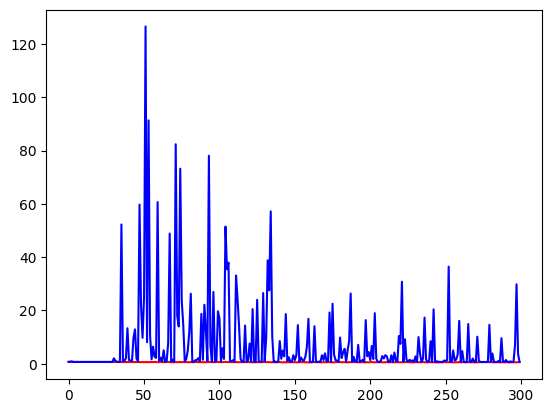

Train loss0.5006636381149292
Valid loss0.6925793687502543


In [27]:
import matplotlib.pyplot as plt
plt.plot(train_loss,'r')
plt.plot(valid_loss,'b')
plt.show()
print("Train loss" + str(min(train_loss)))
print("Valid loss" + str(min(valid_loss)))